<a href="https://colab.research.google.com/github/virf96/Chat-Bot/blob/master/DatosFaltantes_SustitucionMediaMediana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sustitución por la Media/Mediana

Los métodos de imputación consisten en estimar los valores faltantes en base a los valores existentes de la variable. El objetivo de cualquier método de imputación es producir un **conjunto completo** de datos que pueda ser utilizado por un algoritmo de aprendizaje de máquina.
Sustitución por la media o la mediana consiste en reemplazar los valores ausentes con la media (si la variable está normalmente distribuida) o la mediana (si la variable tiene una distribución sesgada).

**Nota**:

- Si la variable tiene una distribución Gaussiana, la media, la mediana y la moda toman aproximadamente el mismo valor. Por lo tanto es equivalente, sustituir valores nulos con la media o la mediana. Sustitución por la moda, no es una práctica muy usada para las variables numéricas.
- Si la variable tiene una distribución sesgada, la media está inclinada hacia los valores que están al extremo de la distribución. Por lo tanto, la mediana es una mejor representación de la mayoría de los valores en una variable. 
- Para las variables discretas de tipo int (que ocupa menos memoria), la media puede que no sea un número entero, por lo tanto tras la imputación, la variable puede ser re-formateada como 'float'. Para evitar este comportamiento, los valores faltantes pueden ser reemplazados por la mediana. La mediana siempre será un entero/ valor discreto también, si la variable original es entera.


### Cuáles variables se pueden sustituir con la media/mediana?

La media y la mediana solo pueden ser calculadas sobre variables numéricas, por lo tanto estos métodos solo son apropiados para variables numéricas.


### Supuestos

- Los datos faltan de forma completamente aleatoria (MCAR)
- Lo más probable es que las observaciones ausentes tengan valores como el de la mayoría de las observaciones en la variable (o sea la media/mediana)

Si los datos faltan de forma completamente aleatoria, entonces es razonable asumir que los valores ausentes estarán probablemente cerca a la media o la mediana de la distribución, ya que estos representan las observaciones más frecuentes/promedio.


### Ventajas

- Fácil de implementar
- Forma rápida de obtener conjuntos completos de datos
- Puede ser integrado en producción (durante el despliegue del modelo)

### Limitaciones

- Distorsión de la distribución original de la variable
- Distorsión de la varianza original
- Distorsión de la covarianza con las otras variables en los datos.

Cuando se sustituyen los valores nulos con la media o la mediana, la varianza de la variable se verá distorsionada si el número de valores faltantes es grande con respecto al número total de las observaciones. 

Adicionalmente, la covarianza y las correlaciones con las otras variables del conjunto de datos se pueden afectar ya que la media/mediana que reemplaza ahora los valores faltantes no necesariamente preserva la relación con las variables restantes.

Finalmente, concentrar todos los valores faltantes alrededor de la media/mediana, puede llevar a que observaciones que normalmente se esperan para dicha distribución, se vean o detecten como valores atípicos  o de baja probabilidad de ocurrencia.

### Cuando usar la sustitución por con la media/mediana?

- Los datos faltan de forma completamente aleatoria (MCAR)
- No más del 5% de las observaciones de la variable tienen datos faltantes

Aunque en teoría, las condiciones anteriores se deberían cumplir para minimizar el impacto de estas técnicas de sustitución, en la práctica, estas se usan comúnmente, así los datos no falten al azar el porcentaje de ausencia sea mayor al 5%. La razón es simple, la técnica es sencilla.


### Nota final

La sustitución de valores nulos por la media/mediana se usa ampliamente en la comunidad de ciencia de datos y en varias competiciones. Por ejemplo, mira la solución ganadora de la copa KDD 2009 : ["Winning the KDD Cup Orange Challenge with Ensemble Selection"]( http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

Típicamente, este tipo de sustitución se usa en conjunto con la adición de una variable binaria llamada "missing indicator" o indicador de ausencia, para capturar las observaciones donde los datos están ausentes (para más detalles ver la clase en "indicador de ausencia"). De esta forma se logran dos cosas: si los valores ausentes son realmente aleatorios, este efecto se captura por la sustitución por media/mediana y si no lo son, el efecto se captura con el indicador. Ambos métodos son fáciles de implementar, y por lo tanto son muy populares en las competencias de ciencia de datos.

## En este demo:

Vamos a aprender cómo implementar la sustitución por la media y la mediana usando pandas y los datos Ames House Price y Titanic.

- Para bajar los datos, por favor referirse a la clase en **Datasets** en la  **Sección 1** del curso.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# dividir los datos 
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Titanic

In [3]:
# cargar los datos del titanic con solo unas columnas

data = pd.read_csv('/content/drive/My Drive/datasets/titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [4]:
# porcentaje de valores faltantes
#Tenemos el 20% de valore faltantes en edad, la cantidad es muy alta para querer imputarla, podría cambiar 
#drasticamente la distribución de la variable.
data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

La media y la mediana utilizadas para reemplazar los valores faltantes, debe estimarse utilizando el set de entrenamiento solamente. Luego, estos parámetros se utilizan para sustituir los datos faltantes en el set de prueba.
Esto significa que el mismo valor de media/mediana deber ser usado para sustituir los valores ausentes en ambos segmentos - entrenamiento y prueba, pero dicho valor se calcula solamente del segmento de entrenamiento. 
Esto se es para evitar sobre-ajustes, y contaminación del segmento de prueba o de los parámetros aprendidos con muestras del set de entrenamiento.

In [5]:
# separemos datos para modelamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # variables
    data['survived'],  # target
    test_size=0.3,  # porcentaje de obs en test set
    random_state=0)  # seed para reproducibilidad

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [7]:
# exploremos datos nulos en el segmento de entrenamiento
# el porcentaje debe ser similar que para todo el 
# conjunto de datos

#El set de entrenamiento tiene ahora el 19% de missing values y 0% de missing values en fare
#Recordemos que ha cambiado porque tenemos el 70% del set original
X_train.isnull().mean()

age     0.191048
fare    0.000000
dtype: float64

In [8]:
# creemos una función para sustituir los valores faltantes
# con la media o la mediana
# la función toma como argumentos:
# dataframe, variable, y el valor de media/mediana
# retorna la variable con los valores sustituidos

def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [9]:
# calcular la mediana de "Age"

median = X_train.age.median()
median

28.0

In [10]:
# calcular el promedio-media de  Age

mean = X_train.age.mean()
mean

30.23144399460189

In [11]:
# creemos una nueva variable con los valores nulos reemplazados
#Utilizaremos la función creado para reemplazar los missing vales con "promedio" y "mediana"
#Después analizaremos que tanto cambio la distribución

# primero reemplazar con la mediana 
X_train['age_median'] = impute_na(X_train, 'age', median)

# ahora reemplazar con la media
X_train['age_mean'] = impute_na(X_train, 'age', mean)

# la media contiene muchos decimales, redondeemos a 1 dígito
# usando NummPy
X_train['age_mean'] = np.round(X_train['age_mean'], 1)

X_train.head(15)

,age,fare,age_median,age_mean
501,13.0,19.5000,13.0,13.0
588,4.0,23.0000,4.0,4.0
402,30.0,13.8583,30.0,30.0
1193,NaN,7.7250,28.0,30.2
686,22.0,7.7250,22.0,22.0
971,NaN,7.8792,28.0,30.2
117,30.0,56.9292,30.0,30.0
540,2.0,26.0000,2.0,2.0
294,49.0,110.8833,49.0,49.0
261,35.0,26.2875,35.0,35.0


Miremos a las filas con valores nulos (NaN) en age, y comparemos con las nuevas variables con los valores sustituidos por ya sea la media 30 o la mediana 28


In [12]:
# vemos como la varianza cambia luego de la sustitución
# esto es de esperarse, porque el porcentaje de valores ausentes 
# es relativamente grande en age, ~20%

#En este caso probamos con el promedio y la mediana dado que la distribución original es parecida a una gaussiana.

print('Varianza variable original: ', X_train['age'].var())
print('Varianza luego de sustitución por mediana: ', X_train['age_median'].var())
print('Varianza luego de sustitución por media: ', X_train['age_mean'].var())

Varianza variable original:  194.16304666581854
Varianza luego de sustitución por mediana:  157.7984295760209
Varianza luego de sustitución por media:  157.02170735199397


La varianza es subestimada, porque ahora muchas observaciones tienen el mismo valor en age (ya sea la media o mediana)


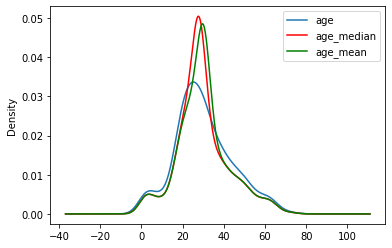

In [13]:
# Comparemos las distribuciones

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original de la variable
X_train['age'].plot(kind='kde', ax=ax)

# distribución variable sustituida con mediana
X_train['age_median'].plot(kind='kde', ax=ax, color='red')

# distribución variable sustituida con media
X_train['age_mean'].plot(kind='kde', ax=ax, color='green')

# etiquetas 
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

La distribución de la variable cambia, ya que ahora hay muchos más valores acumulados hacia la media o la mediana.

**Es esto importante?**

Depende del modelo de machine learning que se quiera construir. Los modelos lineales asumen que las variables están normalmente distribuidas. La sustitución por la media/mediana puede distorsionar la distribución normal original si el porcentaje de valores ausentes es alto y por lo tanto afectar el desempeño del modelo lineal.


In [14]:
# la sustitución por media / mediana también puede afectar
# la relación con las otras variables en los datos

X_train[['fare', 'age', 'age_median', 'age_mean']].cov()

,fare,age,age_median,age_mean
fare,2248.326729,136.176223,114.961682,110.198311
age,136.176223,194.163047,194.163047,194.159033
age_median,114.961682,194.163047,157.798430,157.035694
age_mean,110.198311,194.159033,157.035694,157.021707


Para ver si la relación entre variables cambio podemos visualizar la correlación y ver como impacto la imputación de valores en el coeficiente de correlación.

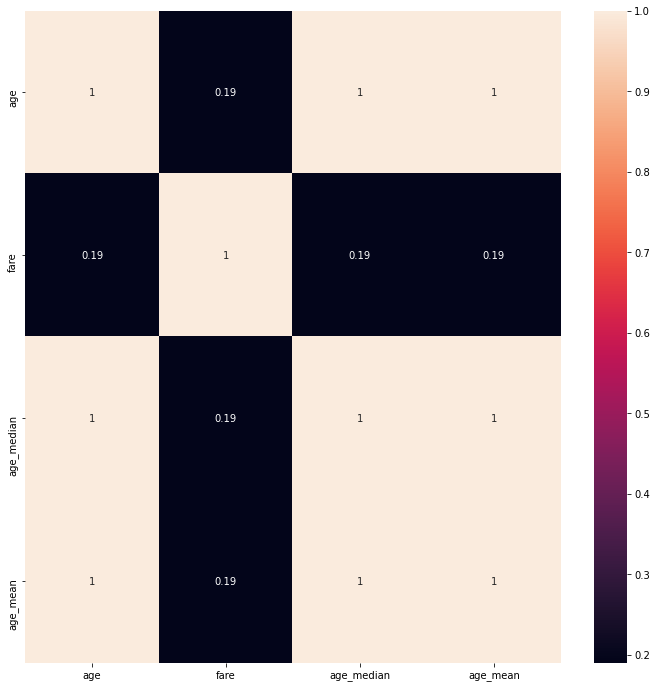

In [18]:
# Calculamos las correlaciones usando pandas corr
# redondeando los valores a 2 decimales
import seaborn as sns
features = X_train.columns
correlation_matrix = X_train[features].corr().round(2)

# Grafiquemos la matriz de correlación usando seaborn
# annot = True para imprimir los coeficientes de correlación


#Podemos ver que la relación de las variables Age, Age_median,Age_mean con Fare es la misma
#Concluimos que en este caso la imputación cambio la distribución pero no la correlación.
figure = plt.figure(figsize=(12, 12))
sns.heatmap(data=correlation_matrix, annot=True)

Podemos ver que la covarianza entre age y fare ha cambiado luego de la sustitución


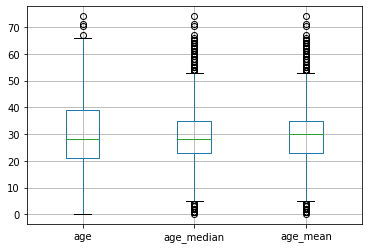

In [19]:
# Finalmente, la sustitución por media / mediana también puede
# generar observaciones que siendo completamente normales parecen
# valores extremos

# o en otras palabras la sustitución puede incrementar
# el número percibido de valores extremos

# analicemos la gráfica de caja

X_train[['age', 'age_median', 'age_mean']].boxplot()

De la gráfica anterior, podemos ver que después de la sustitución hay más valores extremos hacia los valores altos de age, pero también para los valores inferiores.

**Es esto importante?**

Si queremos identificar los verdaderos valores extremos, es importante tener en cuenta este comportamiento. En la práctica, este tipo de efectos son ignorados, pero es importante saber que está sucediendo. Si es necesario, el orden de los pasos en el pre-procesamiento puede adaptarse para tener en cuenta este tipo de efectos.

## House Prices Dataset

Repitamos rápidamente el mismo ejercicio con el House Prices dataset.


In [20]:
# usaremos las siguientes variables, de las cuales solo 3 
# tienen valores nulos

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [21]:
# House Prices dataset

data = pd.read_csv('/content/drive/My Drive/datasets/houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [22]:
# variables con valores nulos

# en la siguiente list comprehension, iteraremos sobre las columnas
# y seleccionaremos las que contienen valores nulos

[var for var in data.columns if data[var].isnull().sum() > 0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [24]:
# porcentaje de valores nulos
#En este ejercicio la única variable que se vería afectada en la imputación por la cantidad de datos faltantes es "LotFrontage"
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

**Recuerda que la media y la mediana que usaremos para sustituir los valores nulos deben ser calculados del segmento de entrenamiento y propagados para el segmento de prueba.

In [25]:
# separemos los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

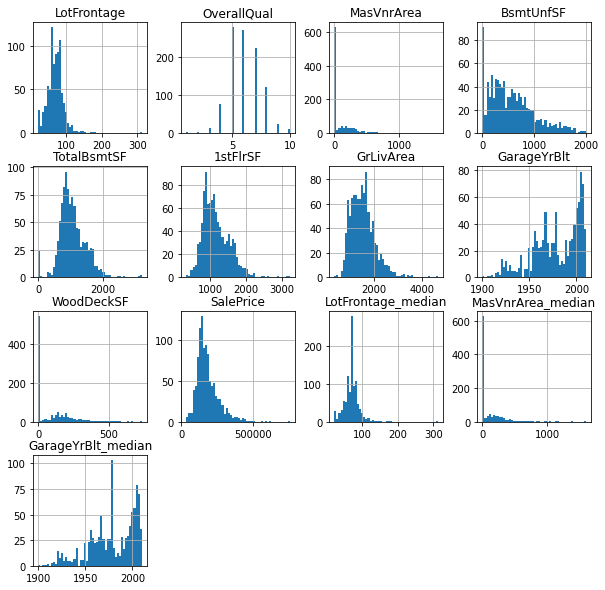

In [30]:
# distribuciones de las variables para el conjunto de entrenamiento que contiene el 70% del set original
#Notamos que "LotFrontage" esta notablemente sesgada a la izquierda
#Notamos que "MasVnrArea" esta sesgada a la izquierda
#Notamos que "GarageYrBlt" esta sesgada a la derecha
#Con esto decidimos emputar con la mediana dado que será un valor más representativo
X_train.hist(bins=50, figsize=(10,10))
plt.show()

In [27]:
# vamos a crear una nueva variable sustituyendo los valores nulos
# con la mediana para cada una de las variables con valores ausentes.

# empecemos con la variable LotFrontage

median = X_train['LotFrontage'].median()

X_train.loc[:,'LotFrontage_median'] = impute_na(X_train, 'LotFrontage', median)
X_test.loc[:,'LotFrontage_median'] = impute_na(X_test, 'LotFrontage', median)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [28]:
median = X_train['MasVnrArea'].median()

X_train.loc[:,'MasVnrArea_median'] = impute_na(X_train, 'MasVnrArea', median)
X_test.loc[:,'MasVnrArea_median'] = impute_na(X_test, 'MasVnrArea', median)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [29]:
median = X_train['GarageYrBlt'].median()

X_train.loc[:, 'GarageYrBlt_median'] = impute_na(X_train, 'GarageYrBlt', median)
X_test.loc[:,'GarageYrBlt_median'] = impute_na(X_test, 'GarageYrBlt', median)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


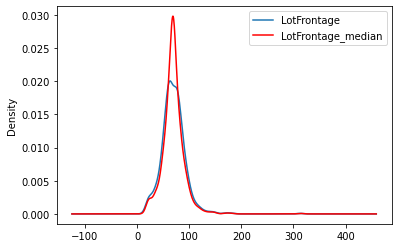

In [31]:
# evaluemos el efecto de la sustitución en las distribuciones

# Los valores se acumulan hacia la mediana en la 
# distribución de LotFrontAge
#Esta variable tenia un sesgo del 17% por lo que es normal ver un cambio en la distribución


fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# variable sustituida con la mediana
X_train['LotFrontage_median'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

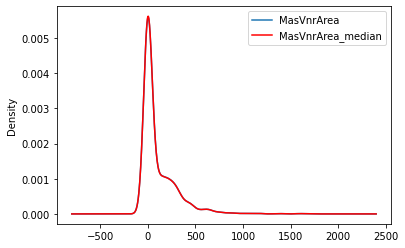

In [32]:
# Para la variable MasVnrArea, dado que los valores faltantes son muy pocos
# no esperamos ver un cambio dramático en la distribución
#Esta variable tenia valores faltantes de .005 por lo que el cambio no debía de ser importante

fig = plt.figure()
ax = fig.add_subplot(111)

# variable original
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# variable imputada
X_train['MasVnrArea_median'].plot(kind='kde', ax=ax, color='red')

# leyendas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

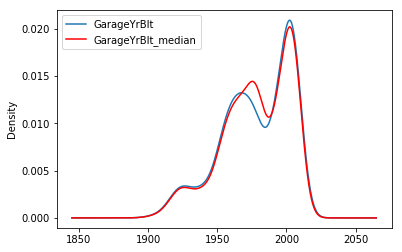

In [ ]:
# Para la variable GarageBlt, dado que el porcentaje de valores nulos
# es menor, no hay un cambio significativo en la distribución
#Esta variable tenia 5% de missing values y notamos que si bien hay un cambio, no es tan drámatico,

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['GarageYrBlt'].plot(kind='kde', ax=ax)

# variable sustitiuida por la mediana
X_train['GarageYrBlt_median'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [33]:
# efecto de la sustitución en la varianza

# Para LotFrontAge hay un cambio significativo ya que el porcetaje
# de valores nulos es alto~20%

print('Varianza original : ', X_train['LotFrontage'].var())
print('Varianza despues de sustitución por mediana: ', X_train['LotFrontage_median'].var())

Varianza original :  532.5872021885676
Varianza despues de sustitución por mediana:  434.06604265416564


In [34]:
# no hay cambios significativo para MasnVnrArea, ya que el % de valores nulos es bajo
print('Varianza original: ', X_train['MasVnrArea'].var())
print('Varianza despues de sustitución por mediana: ', X_train['MasVnrArea_median'].var())

Varianza original:  32983.538710039466
Varianza despues de sustitución por mediana:  32874.27007404175


In [35]:
# no hay cambios significativo para GarageBlt, ya que el % de valores nulos es bajo

print('Varianza original: ', X_train['GarageYrBlt'].var())
print('Varianza despues de sustitución por mediana: ', X_train['GarageYrBlt_median'].var())

Varianza original:  624.3059475074134
Varianza despues de sustitución por mediana:  591.3356883144767


In [36]:
# Exploremos la covarianza:
# tómate el tiempo de comparar los valores en la tabla
# y observa cómo la covarianza es afectada por LotFrontAge pero no mucho 
# por las otras dos variables
X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_median,MasVnrArea_median,GarageYrBlt_median
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.744233e+02,28.095264
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,5.384774,1.005330e+02,16.875386
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,553.921303,3.298354e+04,1134.380889
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,788.095358,7.472110e+03,1724.141544
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2370.929189,2.465436e+04,2989.473391
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,2750.747094,2.080136e+04,1890.271636
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3189.685753,3.496714e+04,2576.345636
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,24.755173,1.182673e+03,624.305948
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,106.009105,3.212101e+03,627.624634
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,544838.836893,6.790442e+06,877485.418108


## Veamos ahora si la relación entre las variables cambio con los diversos casos de missing values que encontramos

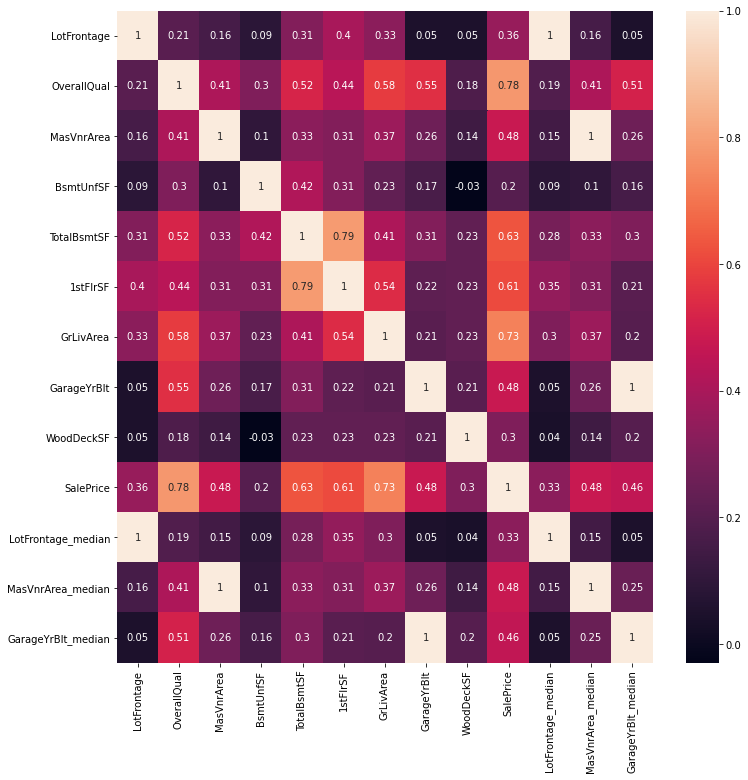

In [37]:
# Podemos notar que solo los valores de "MasVnrArea" no cambiaron, habría que destacar que solo tenía el .005 de missing values
#La variable de "GarageYrBlt" si cambio su relación con las demás variables, teniendo un 5% de missing values
#La variable de "LotFrontage" si cambio su relación con las demás variables, teniendo un 17% de missing values


features = X_train.columns
correlation_matrix = X_train[features].corr().round(2)

# Grafiquemos la matriz de correlación usando seaborn
# annot = True para imprimir los coeficientes de correlación


#Podemos ver que la relación de las variables Age, Age_median,Age_mean con Fare es la misma
#Concluimos que en este caso la imputación cambio la distribución pero no la correlación.
figure = plt.figure(figsize=(12, 12))
sns.heatmap(data=correlation_matrix, annot=True)

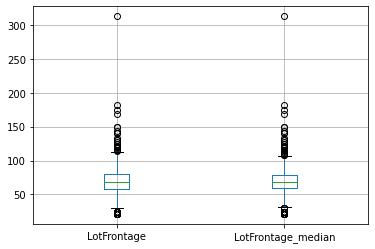

In [38]:
# Exploremos los valores extremos

# hay una disminución en los límites para LotFrontage
# (mira el tamaño de la caja) 
# pero no sucede para las otras dos variables

X_train[['LotFrontage', 'LotFrontage_median']].boxplot()

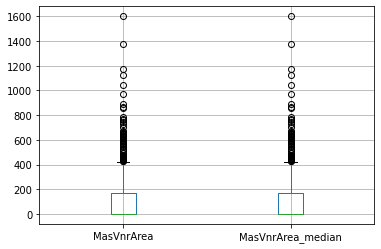

In [39]:
X_train[['MasVnrArea', 'MasVnrArea_median']].boxplot()

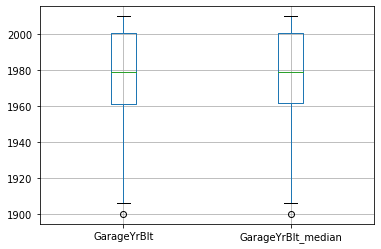

In [40]:
X_train[['GarageYrBlt', 'GarageYrBlt_median']].boxplot()